In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# Load datasets
#ds_moc = xr.open_dataset("../CESM_data/CESM1LE_MOC_NAtl_20N-50N_19200101_20051201.nc")
ds_sst = xr.open_dataset("../CESM_data/CESM1LE_sst_NAtl_19200101_20051201.nc")['sst'][21:54,:,:,:]
#ds_FLNS = xr.open_dataset("../CESM_data/CESM1LE_FLNS_NAtl_19200101_20051201.nc")['FLNS'][21:54,0:89,:,:]
#ds_FSNS = xr.open_dataset("../CESM_data/CESM1LE_FSNS_NAtl_19200101_20051201.nc")['FSNS'][21:54,0:89,:,:]
#ds_LHFLX = xr.open_dataset("../CESM_data/CESM1LE_LHFLX_NAtl_19200101_20051201.nc")['LHFLX'][21:54,0:89,:,:]
#ds_NHFLX = xr.open_dataset("../CESM_data/CESM1LE_NHFLX_NAtl_19200101_20051201.nc")['NHFLX'][21:54,0:89,:,:]
#ds_SHFLX = xr.open_dataset("../CESM_data/CESM1LE_SHFLX_NAtl_19200101_20051201.nc")['SHFLX'][21:54,0:89,:,:]
ds_sss = xr.open_dataset("../CESM_data/CESM1LE_sss_NAtl_19200101_20051201.nc")['sss'][21:54,0:89,:,:]

In [3]:
# Function for removing the seasonal cycle from the loadedDataArray
def deseason(ds):
    data = ds.T.values
    monthly_means = np.zeros((42,86,12,89,33))
    
    iyr = 0
    for it in range(1032):
        mo_ind = it%12
        monthly_means[:,iyr,mo_ind,:,:] = data[:,it,:,:]
        if mo_ind==11:
            iyr+=1
    monthly_means = np.nanmean(monthly_means,axis=1)
    
    data_deseason = np.zeros(data.shape)
    for it in range(1032):
        mo_ind = it%12
        data_deseason[:,it,:,:] = data[:,it,:,:] - monthly_means[:,mo_ind,:,:]
    
    data_deseason[np.isnan(data_deseason)] = 0
    return data_deseason



In [12]:
%%time
# Deseason the data
sst_deseasoned = deseason(ds_sst)
#FLNS_deseasoned = deseason(ds_FLNS)
#FSNS_deseasoned = deseason(ds_FSNS)
#LHFLX_deseasoned = deseason(ds_LHFLX)
#NHFLX_deseasoned = deseason(ds_NHFLX)
#SHFLX_deseasoned = deseason(ds_SHFLX)
sss_deseasoned = deseason(ds_sss)

/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 17.9 s, sys: 2.48 s, total: 20.4 s
Wall time: 20.4 s


In [13]:
%%time
# Normalize the data
sst_normed = (sst_deseasoned - np.mean(sst_deseasoned))/np.std(sst_deseasoned)
sss_normed = (sss_deseasoned - np.mean(sss_deseasoned))/np.std(sss_deseasoned)

CPU times: user 1.62 s, sys: 847 ms, total: 2.46 s
Wall time: 2.47 s


Text(0, 0.5, 'Normalized Value')

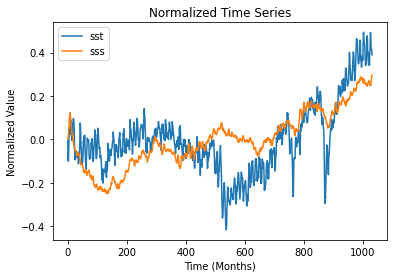

In [18]:
# Test Plot of normalized data
plt.plot(np.mean(sst_normed,axis=(0,2,3)))
plt.plot(np.mean(sss_normed,axis=(0,2,3)))
plt.legend(['sst','sss'])
plt.title("Normalized Time Series")
plt.xlabel("Time (Months)")
plt.ylabel("Normalized Value")

In [15]:
sst_normed.shape

(42, 1032, 89, 33)

In [16]:
%%time
np.save("CESM_SST_normalized.npy",sst_normed)

In [17]:
%%time
np.save("CESM_SSS_normalized.npy",sss_normed)